# Deep Learning approach for single-cell RNA-seq data analysis

In [15]:
import os
import time
import warnings
import scanpy as sc
import anndata
import scvi
import torch
import pandas as pd
import numpy as np

start_time = time.time()


scvi.settings.seed = 0
scvi.settings._dl_pin_memory_gpu_training = 20000

sc.set_figure_params(figsize=(5, 5))
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tensor_high_precision = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float64, device=device)
torch.set_float32_matmul_precision('high')

save_dir = os.getcwd()

Global seed set to 0


In [16]:
print("Used versions:")
print("scvi-tools version:", scvi.__version__)
print("scanpy version:", sc.__version__)
print("torch version:", torch.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("Save dir:", save_dir)

Used versions:
scvi-tools version: 1.0.3
scanpy version: 1.9.5
torch version: 2.1.1+cu121
pandas version: 1.5.3
numpy version: 1.23.5
Save dir: C:\Users\mathi\OneDrive - Hogeschool Leiden\Documenten\Jaar 3\BPEXA_Git\bpexa


In [17]:
data_0h_A = sc.read_10x_h5("data/0h_A_raw_feature_bc_matrix.h5")
data_0h_B = sc.read_10x_h5("data/0h_B_raw_feature_bc_matrix.h5")
data_48h = sc.read_10x_h5("data/48h_raw_feature_bc_matrix.h5")
data_120h = sc.read_10x_h5("data/120h_raw_feature_bc_matrix.h5")

In [18]:
data_0h_A.obs['run'] = "0h_A"
data_0h_B.obs['run'] = "0h_B"
data_48h.obs['run'] = "48h"
data_120h.obs['run'] = "120h"

In [19]:
sc.pp.filter_genes(data_0h_A, min_cells=3)
sc.pp.filter_genes(data_0h_B, min_cells=3)
sc.pp.filter_genes(data_48h, min_cells=3)
sc.pp.filter_genes(data_120h, min_cells=3)

In [20]:
sc.pp.filter_cells(data_0h_A, min_counts=200)
sc.pp.filter_cells(data_0h_B, min_counts=200)
sc.pp.filter_cells(data_48h, min_counts=200)
sc.pp.filter_cells(data_120h, min_counts=200)

In [21]:
data_0h_A.var_names_make_unique()
data_0h_B.var_names_make_unique()
data_48h.var_names_make_unique()
data_120h.var_names_make_unique()

In [22]:
data_list = [data_0h_A, data_0h_B, data_48h, data_120h]
keys = ['batch_2_A', 'batch_2_B', 'batch_1_sample_48H', 'batch_1_sample_120H']
for data, key in zip(data_list, keys):
    data.obs_names = key + '_' + data.obs_names

adata = anndata.concat(data_list, join="outer")

In [23]:
sample_names = pd.read_table("data/sample_name_full_dataset.tsv")
sample_names.rename(columns={'Unnamed: 0': 'Sample', 'sample_name': 'Batch'}, inplace=True)
sample_names.set_index('Sample', inplace=True)
adata.obs['batch'] = adata.obs_names.map(sample_names['Batch'])

In [24]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top= None, log1p=False, inplace=True)

In [25]:
data = pd.DataFrame(data=adata.obs)
data.head()

,run,n_counts,batch,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
batch_2_A_AAACCCAAGGTAATCA-1,0h_A,48806.0,iPSC_99_4,6892,48806.0,2494.0,5.110028
batch_2_A_AAACCCAAGGTACCTT-1,0h_A,42383.0,iPSC_20_6_4,6574,42383.0,2371.0,5.594224
batch_2_A_AAACCCAGTCGTTCAA-1,0h_A,15016.0,iPSC_54_3,3975,15016.0,881.0,5.867075
batch_2_A_AAACCCATCACAGTGT-1,0h_A,37052.0,iPSC_72_1,6262,37052.0,1978.0,5.338443
batch_2_A_AAACCCATCCCTCTCC-1,0h_A,2387.0,iPSC_72_1,374,2387.0,1977.0,82.823631


In [26]:
subset_condition = (
    (adata.obs['n_genes_by_counts'] > 2000) &
    (adata.obs['n_genes_by_counts'] < 7000) &
    (adata.obs['n_counts'] < 100000) &
    (adata.obs['pct_counts_mt'] < 10) &
    (adata.obs['pct_counts_mt'] > 0.1)
)
adata = adata[subset_condition, :]

## Normalization

In [27]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [28]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    layer="counts",
    flavor='seurat_v3',
    subset=True
)

In [29]:
training_size = 0.9
while np.ceil((len(adata) * training_size) % 128) == 1: training_size -= 0.01
print(f"Current training_size: {training_size}")

Current training_size: 0.89


## Training model

In [30]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

In [31]:
model = scvi.model.SCVI(adata)
model.train(batch_size = 128, train_size=training_size, max_epochs=100)
model_dir = os.path.join(save_dir, "scvi_model")
model.save(model_dir, overwrite=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:42<00:00,  2.50it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.4e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s, v_num=1, train_loss_step=1.36e+3, train_loss_epoch=1.4e+3]


In [32]:
t_model = scvi.model.SCVI.load("scvi_model/", adata=adata)

INFO     File scvi_model/model.pt already downloaded                                                               


In [33]:
t_model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [34]:
adata.obsm["X_scvi"] = t_model.get_latent_representation()
#adata.layers['scvi_normalized'] = t_model.get_normalized_expression(libray_size = 1e4)

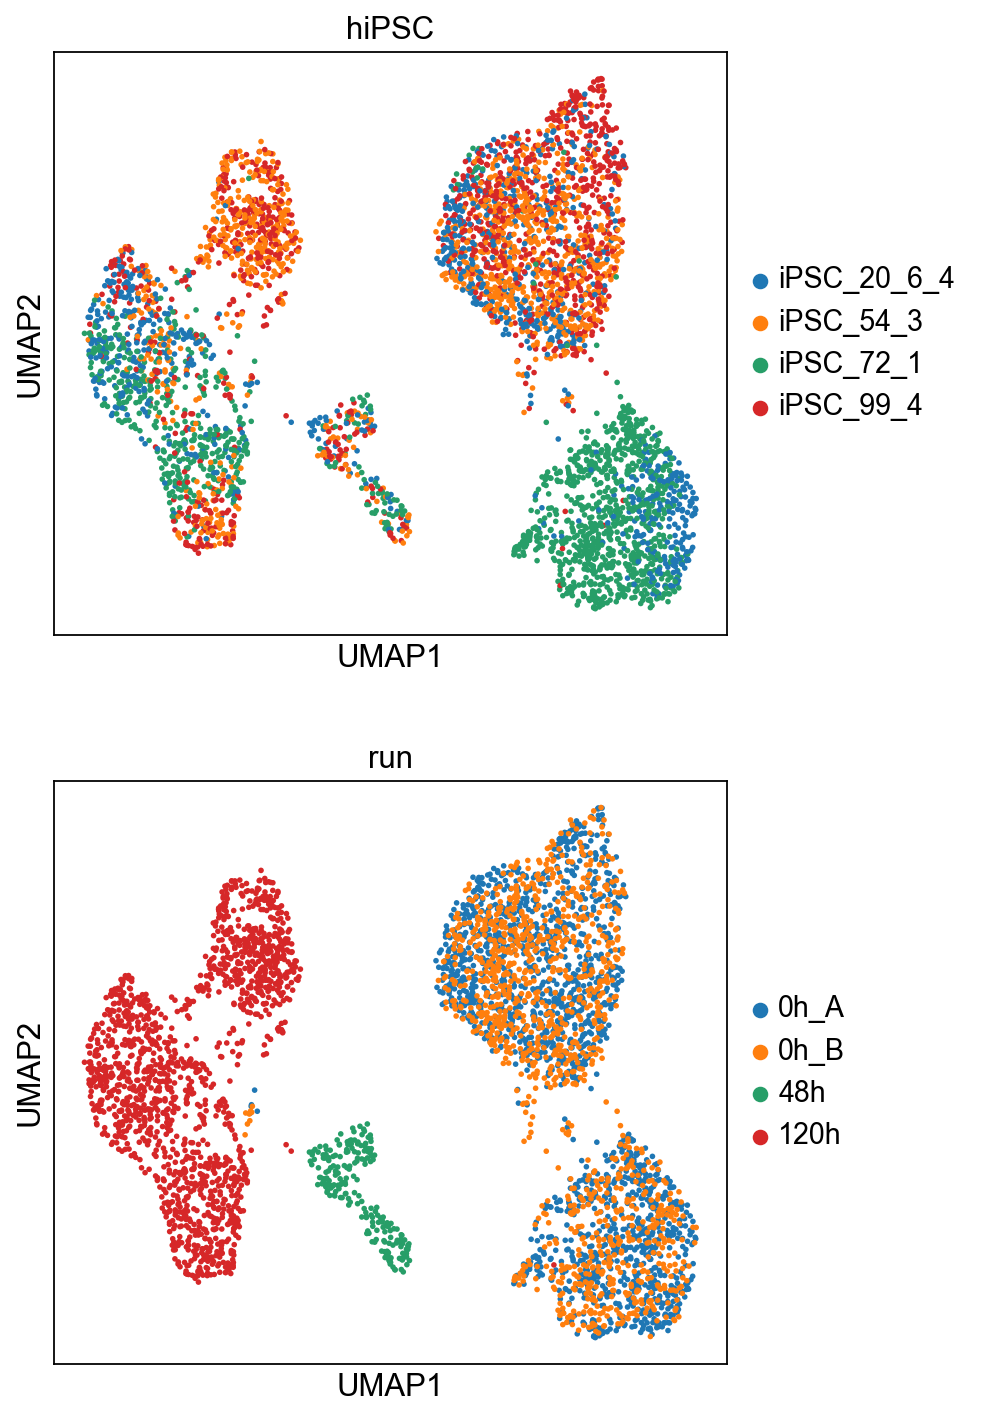

as


In [35]:
sc.pp.neighbors(adata, method='umap', use_rep="X_scvi")
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    title="hiPSC",
    color=["batch", "run"],
    ncols=1
)


In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Duration:{ elapsed_time} seconds")